# Kernels / Covariance functions

The following are a series of examples covering each available covariance function, and demonstrating allowed operations.  The API will be familiar to users of [GPy](https://github.com/SheffieldML/GPy) or [GPflow](https://github.com/GPflow/GPflow), though ours is simplified.  All covariance function parameters can be assigned prior distributions or hardcoded.  MCMC methods or optimization methods can be used for inference.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
%matplotlib inline

import numpy as np
np.random.seed(206)
import theano
import theano.tensor as tt
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

In [2]:
X = np.linspace(0,2,200)[:,None]

# function to display covariance matrices
def plot_cov(X, K, stationary=True):
    K = K + 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(121)
    m = ax1.imshow(K, cmap="inferno", 
                   interpolation='none', 
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X))); 
    plt.colorbar(m);
    ax1.set_title("Covariance Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")
    
    ax2 = fig.add_subplot(122)
    if not stationary:
        ax2.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax2.set_title("The Diagonal of K")
        ax2.set_ylabel("k(x,x)")
    else:
        ax2.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax2.set_title("K as a function of x - x'")
        ax2.set_ylabel("k(x,x')")
    ax2.set_xlabel("X")

    fig = plt.figure(figsize=(14,4))
    ax = fig.add_subplot(111)
    samples = np.random.multivariate_normal(np.zeros(200), K, 5).T;
    for i in range(samples.shape[1]):
        ax.plot(x, samples[:,i], color=cmap.inferno(i*0.2), lw=2);
    ax.set_title("Samples from GP Prior")
    ax.set_xlabel("X")

## Exponentiated Quadratic

The lengthscale $l$, overall scaling $\tau$, and constant bias term $b$ can be scalars or PyMC3 random variables.

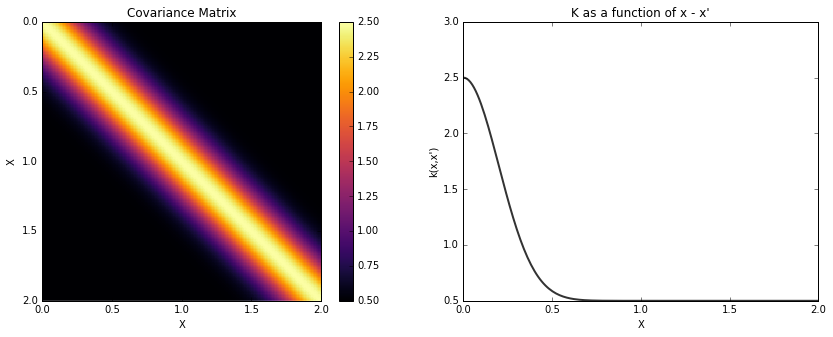

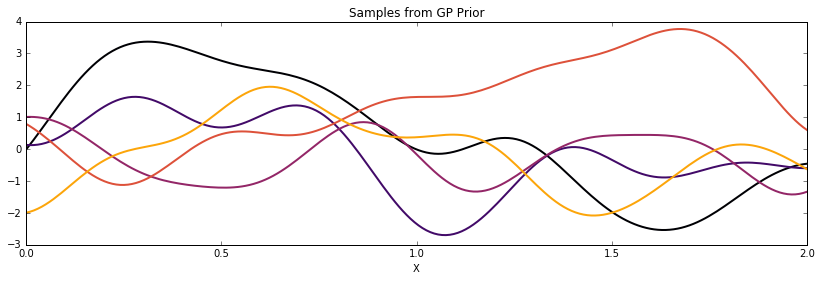

In [3]:
with pm.Model() as model:
    l = 0.2 
    tau = 2.0
    b = 0.5
    cov = b + tau * pm.gp.cov.ExpQuad(1, l)

K = theano.function([], cov.K(X))()
plot_cov(X, K)

## Two (and higher) Dimensional Inputs
## Both dimensions active

It is easy to define kernels with higher dimensional inputs.  Notice that the ```lengthscales``` parameter is an array of length 2.  Lists of PyMC3 random variables can be used for automatic relevance determination (ARD).

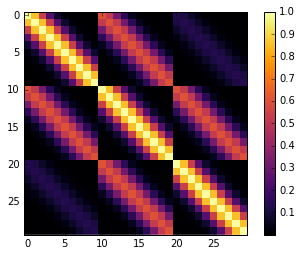

In [4]:
x1, x2 = np.meshgrid(np.linspace(0,1,10), np.arange(1,4))
X2 = np.concatenate((x1.reshape((30,1)), x2.reshape((30,1))), axis=1)

with pm.Model() as model:
    l = np.array([0.2, 1.0])
    cov = pm.gp.cov.ExpQuad(input_dim=2, lengthscales=l)
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

## One dimension active

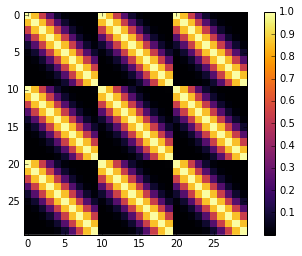

In [5]:
with pm.Model() as model:
    l = 0.2
    cov = pm.gp.cov.ExpQuad(input_dim=2, lengthscales=l, 
                            active_dims=[True, False])
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

## Product of two covariances, active over each dimension

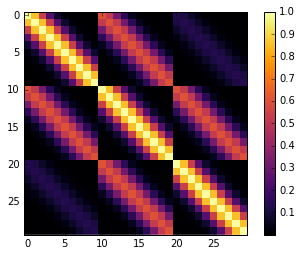

In [6]:
with pm.Model() as model:
    l1 = 0.2
    l2 = 1.0
    cov1 = pm.gp.cov.ExpQuad(2, l1, active_dims=[True, False])
    cov2 = pm.gp.cov.ExpQuad(2, l2, active_dims=[False, True])
    cov = cov1 * cov2
K = theano.function([], cov.K(X2))()
m = plt.imshow(K, cmap="inferno", interpolation='none'); plt.colorbar(m);

## White Noise

In our design, there is no need for a white noise kernel.  This case can be handled with Theano.  The following is a covariance function that is 5% white noise.

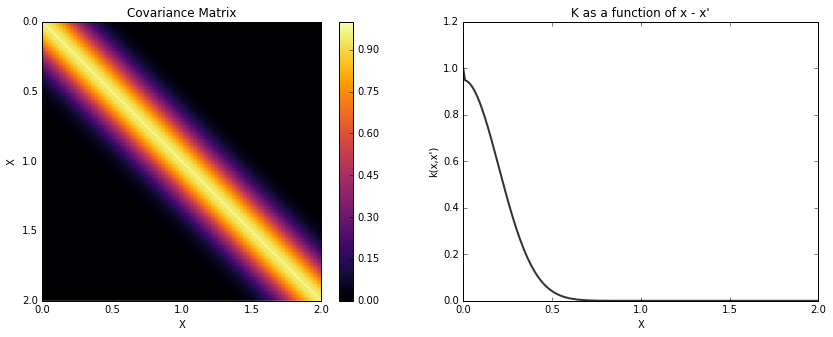

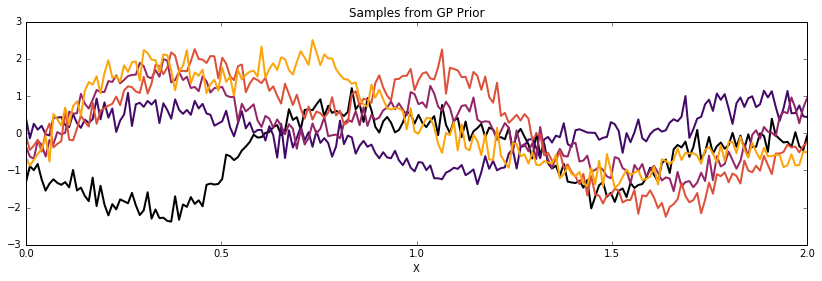

In [7]:
with pm.Model() as model:
    l = 0.2
    sigma2 = 0.05
    tau = 0.95
    cov_latent = tau * pm.gp.cov.ExpQuad(1, l)
    cov_noise = sigma2 * tt.eye(200)
    
K = theano.function([], cov_latent.K(X) + cov_noise)()
plot_cov(X, K)

## Rational Quadratic

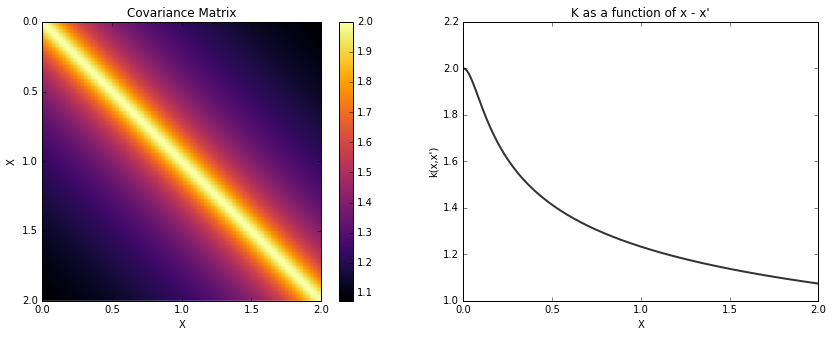

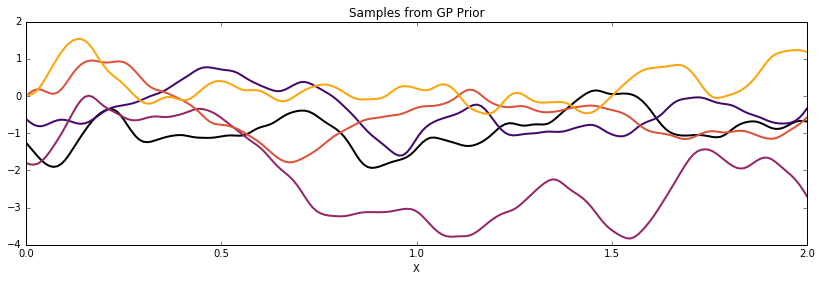

In [8]:
with pm.Model() as model:
    alpha = 0.1
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.RatQuad(1, l, alpha)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Exponential

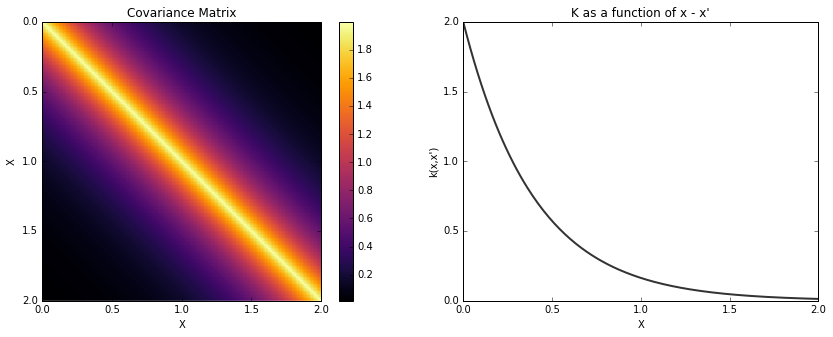

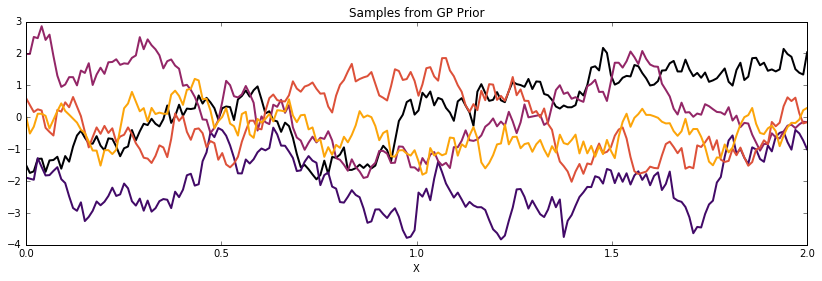

In [9]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Exponential(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Matern 5/2

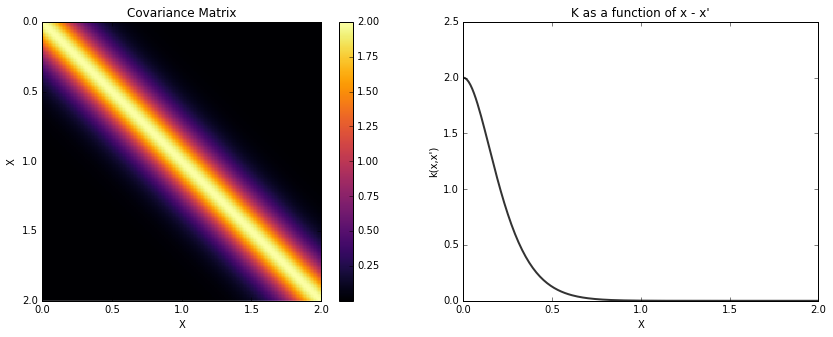

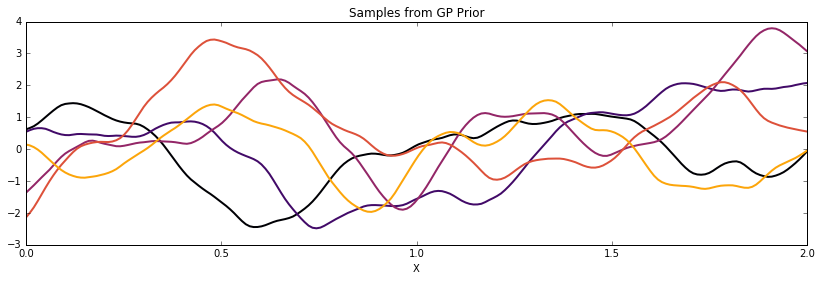

In [10]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern52(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Matern 3/2

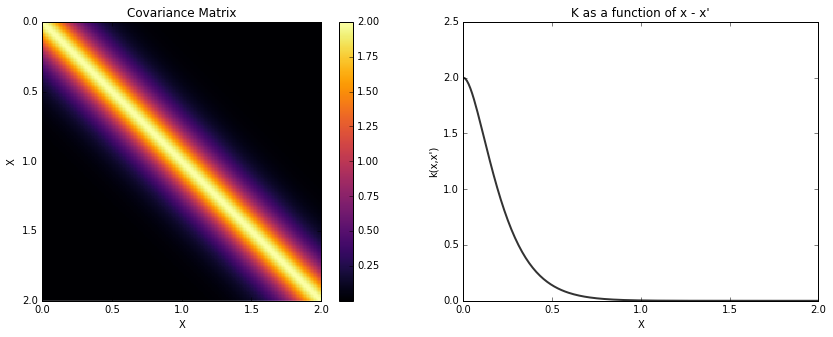

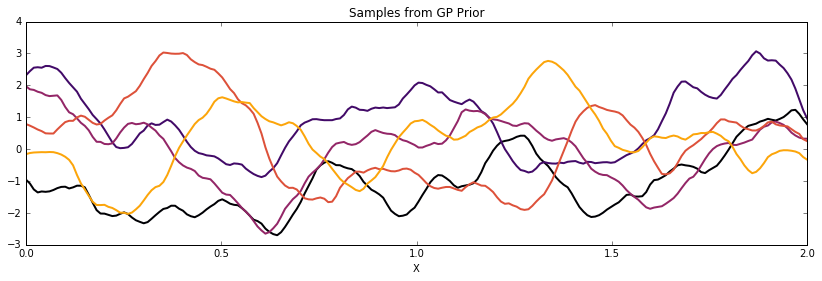

In [11]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Matern32(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Cosine

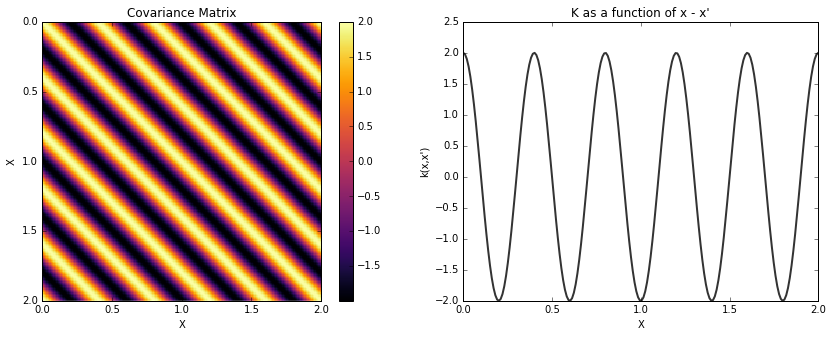

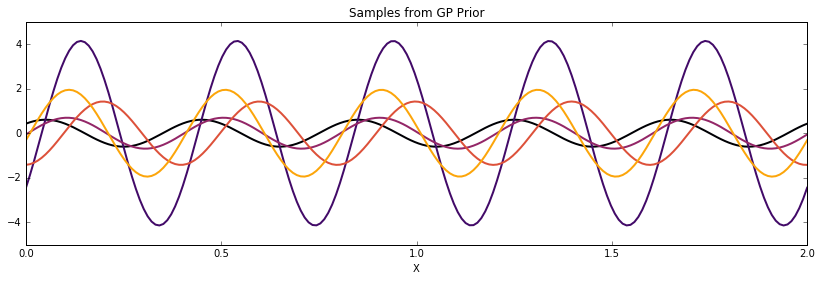

In [12]:
with pm.Model() as model:
    l = 0.2
    tau = 2.0
    cov = tau * pm.gp.cov.Cosine(1, l)

K = theano.function([], cov.K(X))()

plot_cov(X, K)

## Linear

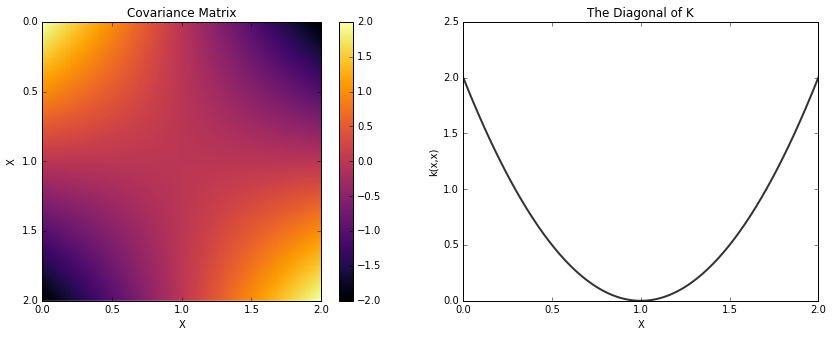

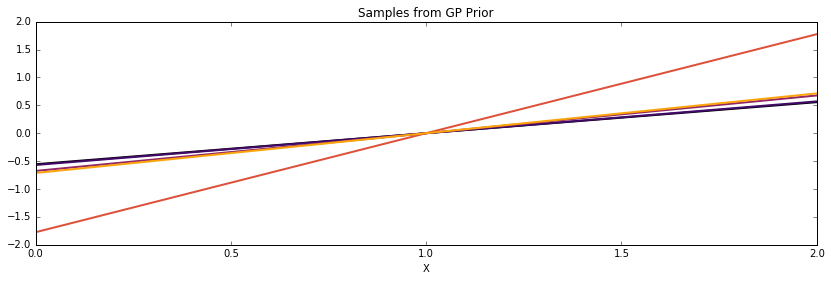

In [13]:
with pm.Model() as model:
    c = 1.0
    tau = 2.0
    cov = tau * pm.gp.cov.Linear(1, c)

K = theano.function([], cov.K(X))()

plot_cov(X, K, False)

## Polynomial

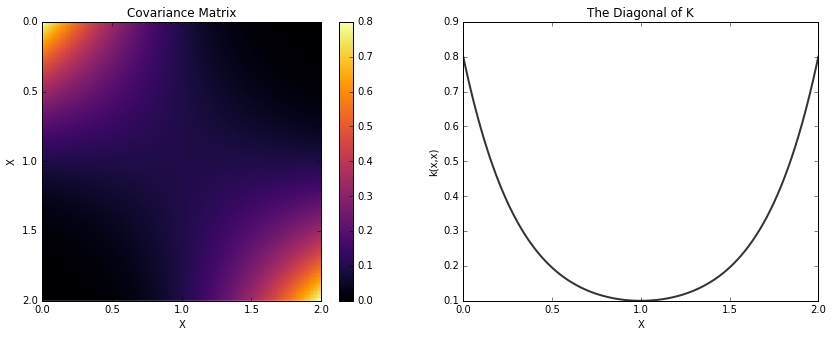

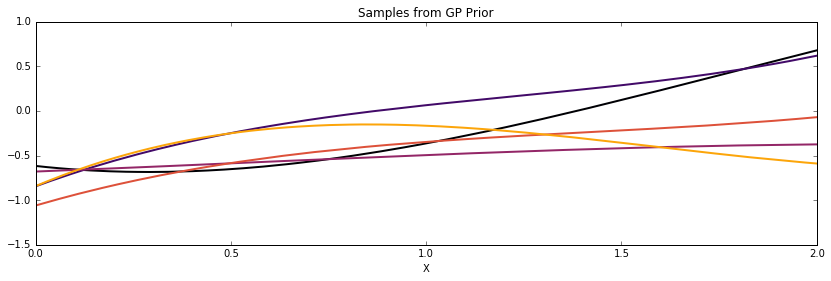

In [14]:
with pm.Model() as model:
    c = 1.0
    d = 3
    offset = 1.0
    tau = 0.1
    cov = tau * pm.gp.cov.Polynomial(1, c=c, d=d, offset=offset)

K = theano.function([], cov.K(X))()

plot_cov(X, K, False)

## Multiplication with a precomputed covariance matrix

A covariance function ```cov``` can be multiplied with numpy matrix, ```K_cos```.

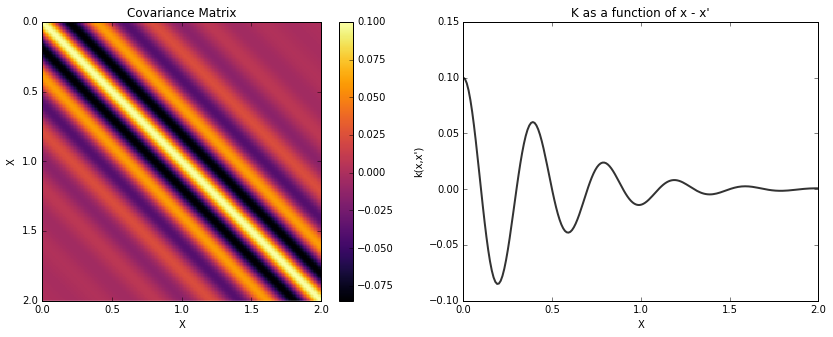

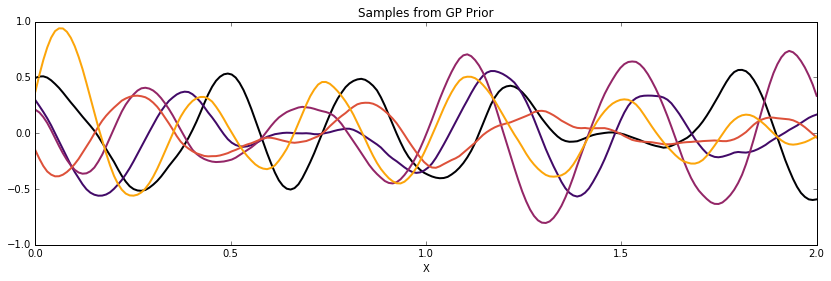

In [15]:
with pm.Model() as model:
    l = 0.2
    cov_cos = pm.gp.cov.Cosine(1, l)
K_cos = theano.function([], cov_cos.K(X))()

    
with pm.Model() as model:
    cov = tau * pm.gp.cov.Matern32(1, 0.5) * K_cos
    
K = theano.function([], cov.K(X))()
plot_cov(X, K)

## Applying an arbitary warping function on the inputs

If $k(x, x')$ is a valid covariance function, then so is $k(w(x), w(x'))$.

The first argument of the warping function must be the input ```X```.  The remaining arguments can be anything else, including (thanks to Theano's symbolic differentiation) random variables.

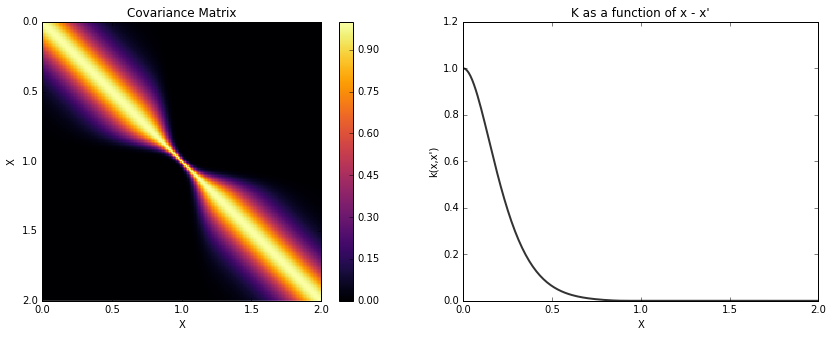

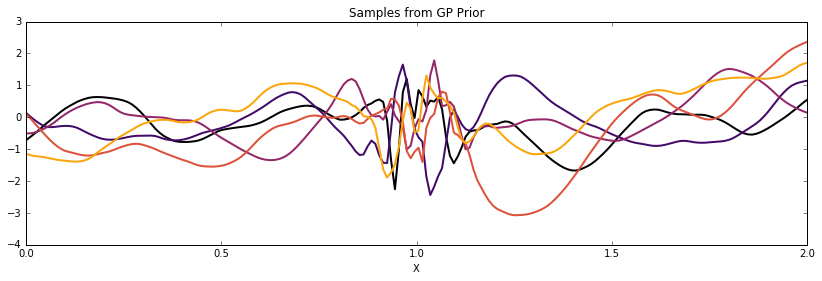

In [16]:
def warp_func(x, a, b, c):
    return x + (a * tt.tanh(b * (x - c)))

with pm.Model() as model:
    a = 1.0
    b = 10.0
    c = 1.0
    
    cov_m52 = pm.gp.cov.Matern52(1, l)
    cov = pm.gp.cov.WarpedInput(1, warp_func=warp_func, args=(a,b,c), cov_func=cov_m52)
    
K = theano.function([], cov.K(X))()
plot_cov(X, K, True)